# CODE


In this file, we have loaded pretrained model of YOLOV3 and UNET-RESNET34. 

We also trained the linear regression model for Distance Estimation in meters.

#### Linear Regression Model

In [1]:
#Loading the libraries.
import numpy as np
import cv2 as cv
import imutils
import subprocess
import time
import os
import matplotlib.pyplot as plt

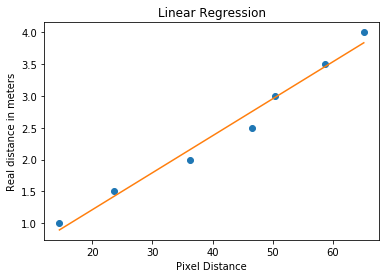

In [2]:
x=np.array([14.5001,23.5645,36.2180,46.5987,50.4541,58.7620,65.1920]) # Real distance recorded in meters.
y=np.array([1,1.5,2,2.5,3,3.5,4])  # compared pixel distance through images
plt.plot(x, y, 'o')
m, b = np.polyfit(x, y, 1)


plt.plot(x, m*x + b)
plt.ylabel("Real distance in meters")
plt.xlabel("Pixel Distance")
plt.title("Linear Regression")
plt.show()

In [3]:
#the image is divided into three parts (Left,Centre,Right) and the object that follows in any of these parts, its distance is calculated with respect to thatpart centre.
def distance(img,a,b):
    if (0<a<img.shape[1]/3):
        dis=np.sqrt(((int(img.shape[1]/6)-a)**2)+((img.shape[0]-b)**2))
    if (img.shape[1]/3<a<img.shape[1]*2/3):
        dis=np.sqrt(((int(img.shape[1]/2)-a)**2)+((img.shape[0]-b)**2))
    if (img.shape[1]*2/3<a<img.shape[1]):
        dis=np.sqrt(((int((img.shape[1]*2/3)+(img.shape[1]/6))-a)**2)+((img.shape[0]-b)**2))
    return dis

In [4]:
from sklearn.linear_model import LinearRegression

In [5]:
linear_model = LinearRegression()
linear_model.fit(x.reshape(-1, 1), y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [6]:
linear_model.score(x.reshape(-1, 1), y)

0.9805541979507485

Accuracy - 98.05%

#### Model for Road Condition Detection

In [7]:
from fastai.vision import *
from fastai.vision.interpret import *
from fastai.callbacks.hooks import *
from pathlib import Path
from fastai.utils.mem import *
from PIL import Image as PImage
torch.backends.cudnn.benchmark=True

In [8]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

In [9]:
path_image=r"A:\unet\images"
path_label=r"A:\unet\labels"
path_clabel=r"A:\unet\colourlabels"
path_codes=r"A:\unet\codes.txt"
path_valid=r"A:\unet\valid.txt"     #loading the data 

In [10]:
codes = np.loadtxt(path_codes, dtype=str); 
codes #Different type of classes

array(['background', 'roadAsphalt', 'roadPaved', 'roadUnpaved', 'roadMarking', 'speedBump', 'catsEye', 'stormDrain',
       'manholeCover', 'patchs', 'waterPuddle', 'pothole', 'craks'], dtype='<U12')

In [11]:
fnames = get_image_files(path_image)
lbl_names = get_image_files(path_label)
get_y_fn = lambda x: path_label+'/'+f'{x.stem}{x.suffix}'

In [12]:
mask = open_mask(get_y_fn(fnames[121]))
src_size = np.array(mask.shape[1:])
src = (SegmentationItemList.from_folder(path_image)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))
size = src_size
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=4)
        .normalize(imagenet_stats))

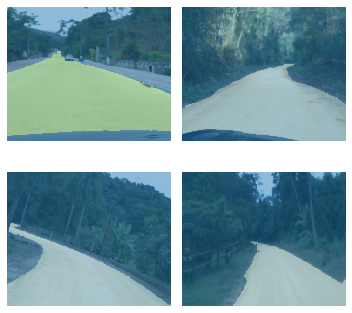

In [13]:
data.show_batch(5, figsize=(5,5)) #example from dataset with there masks

In [14]:
name2id = {v:k for k,v in enumerate(codes)}

def acc_rtk(input, target):
    target = target.squeeze(1)
    mask = target != 0
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

metrics=acc_rtk
wd=1e-2

In [15]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)
learn=load_learner(r'A:\unet\images\models','my_export.pkl')         # loading the self-trained model(from UNETRESNET34 train file)

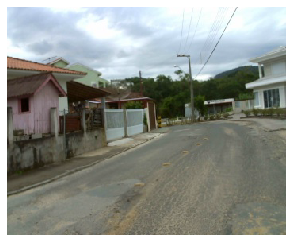

In [16]:
img_f = fnames[34]
img = open_image(img_f)
img.show(figsize=(5,5))

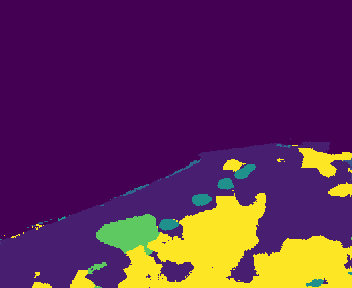

In [17]:
prediction = learn.predict(img)
prediction[0]  #mask predicted

In [18]:
%load_ext cython

In [19]:
%%cython -a
import cython
cimport numpy
import cv2 as cv
import numpy as np


#Coloring the masks by proper values of RGB
 
@cython.boundscheck(False)
@cython.wraparound(False)
#def colorfull_fast(numpy.ndarray[numpy.uint8_t, ndim=3, mode="c"] frame):
cpdef numpy.ndarray[numpy.uint8_t, ndim=3, mode="c"] colorfull_fast(numpy.ndarray[numpy.uint8_t, ndim=3, mode="c"] frame):
  # set the variable extension types
  cdef int x, y, width, height, b, g, r

  #frame = cv.imdecode(np.frombuffer(byteframe, np.uint8), -1)

  # grab the image dimensions
  width = 288
  height = 352
    
  # loop over the image, pixel by pixel
  for x in range(width):
    for y in range(height):
      b, g, r = frame[x, y]
      if (b, g, r) == (0,0,0): #background
        frame[x, y] = (0,0,0)
      elif (b, g, r) == (1,1,1): #roadAsphalt
        frame[x, y] = (0,0,125)
      elif (b, g, r) == (2,2,2): #roadPaved
        frame[x, y] = (0,0,125)
      elif (b, g, r) == (3,3,3): #roadUnpaved
        frame[x, y] = (0,0,125) 
      elif (b, g, r) == (4,4,4): #roadMarking
        frame[x, y] = (0,0,125) 
      elif (b, g, r) == (5,5,5): #speedBump
        frame[x, y] = (0,0,125)
      elif (b, g, r) == (6,6,6): #catsEye
        frame[x, y] = (0,0,125)          
      elif (b, g, r) == (7,7,7): #stormDrain
        frame[x, y] = (0,0,125) 
      elif (b, g, r) == (8,8,8): #manholeCover
        frame[x, y] = (0,0,125) 
      elif (b, g, r) == (9,9,9): #patchs
        frame[x, y] = (127,0,0) 
      elif (b, g, r) == (10,10,10): #waterPuddle
        frame[x, y] = (100,100,0)
      elif (b, g, r) == (11,11,11): #pothole
        frame[x, y] = (255,0,0)
      elif (b, g, r) == (12,12,12): #cracks
        frame[x, y] = (255,100,0)
 
  frame = cv.cvtColor(frame,cv.COLOR_BGR2RGB)
  
  # return the colored image
  return frame

In [20]:
frame = colorfull_fast(cv.cvtColor(image2np(prediction[0].data).astype(np.uint8), cv.COLOR_GRAY2RGB)) # colouring the predicted mask to represent each class uniquely

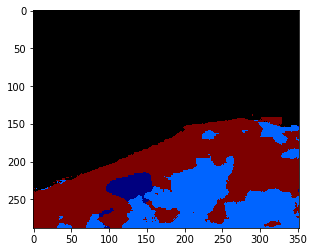

In [21]:
plt.imshow(frame)

#### Model for Object Detection 

In [22]:
def draw_labels_and_boxes(img, boxes, confidences, classids, idxs, colors, labels):
    # If there are any detections
    if len(idxs) > 0:
        for i in idxs.flatten():
            # Get the bounding box coordinates
            x, y = boxes[i][0], boxes[i][1]
            w, h = boxes[i][2], boxes[i][3]
            
            a=x+int(w/2)
            b=y+h
            dis=distance(img,a,b)
            y_pred = linear_model.predict(np.array(dis).reshape(1,-1))
        
            # Get the unique color for this class
            color = [int(c) for c in colors[classids[i]]]

            # Draw the bounding box rectangle and label on the image
            cv.rectangle(img, (x, y), (x+w, y+h), color, 2)
            text = "{}: {:.2f}".format(labels[classids[i]],float(y_pred[0]))
            cv.putText(img, text, (x, y-5), cv.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
            
            
    return img

In [23]:
def generate_boxes_confidences_classids(outs, height, width, tconf):
    boxes = []
    confidences = []
    classids = []

    for out in outs:
        for detection in out:
            #print (detection)
            #a = input('GO!')

            # Get the scores, classid, and the confidence of the prediction
            scores = detection[5:]
            classid = np.argmax(scores)
            confidence = scores[classid]

            # Consider only the predictions that are above a certain confidence level
            if confidence > tconf:
                # TODO Check detection
                box = detection[0:4] * np.array([width, height, width, height])
                centerX, centerY, bwidth, bheight = box.astype('int')

                # Using the center x, y coordinates to derive the top
                # and the left corner of the bounding box
                x = int(centerX - (bwidth / 2))
                y = int(centerY - (bheight / 2))

                # Append to list
                boxes.append([x, y, int(bwidth), int(bheight)])
                confidences.append(float(confidence))
                classids.append(classid)

    return boxes, confidences, classids

In [24]:
def infer_image(net, layer_names, height, width, img, colors, labels, 
            boxes=None, confidences=None, classids=None, idxs=None, infer=True):

    if infer:
        # Contructing a blob from the input image
        blob = cv.dnn.blobFromImage(img, 1 / 255.0, (416, 416),
                        swapRB=True, crop=False)

        # Perform a forward pass of the YOLO object detector
        net.setInput(blob)

        # Getting the outputs from the output layers
        outs = net.forward(layer_names)



        # Generate the boxes, confidences, and classIDs
        boxes, confidences, classids = generate_boxes_confidences_classids(outs, height, width,0.5)

        # Apply Non-Maxima Suppression to suppress overlapping bounding boxes
        idxs = cv.dnn.NMSBoxes(boxes, confidences,0.5, 0.3)

    if boxes is None or confidences is None or idxs is None or classids is None:
        raise '[ERROR] Required variables are set to None before drawing boxes on images.'

    # Draw labels and boxes on the image
    img = draw_labels_and_boxes(img, boxes, confidences, classids, idxs, colors, labels)

    return img, boxes, confidences, classids, idxs


In [25]:
weights=r"C:\Users\HP\Desktop\Resources\Demo\yolov3.weights"
cfg=r"C:\Users\HP\Desktop\Resources\Demo\cfg\yolov3.cfg"
labels=r"C:\Users\HP\Desktop\Resources\Demo\coco-labels"
confidence=0.5
threshold=0.3                      #Loading the data

In [26]:
# Get the labels
labels = open(labels).read().strip().split('\n')

In [27]:
labels

['person',
 'bicycle',
 'car',
 'motorbike',
 'aeroplane',
 'bus',
 'train',
 'truck',
 'boat',
 'traffic light',
 'fire hydrant',
 'stop sign',
 'parking meter',
 'bench',
 'bird',
 'cat',
 'dog',
 'horse',
 'sheep',
 'cow',
 'elephant',
 'bear',
 'zebra',
 'giraffe',
 'backpack',
 'umbrella',
 'handbag',
 'tie',
 'suitcase',
 'frisbee',
 'skis',
 'snowboard',
 'sports ball',
 'kite',
 'baseball bat',
 'baseball glove',
 'skateboard',
 'surfboard',
 'tennis racket',
 'bottle',
 'wine glass',
 'cup',
 'fork',
 'knife',
 'spoon',
 'bowl',
 'banana',
 'apple',
 'sandwich',
 'orange',
 'broccoli',
 'carrot',
 'hot dog',
 'pizza',
 'donut',
 'cake',
 'chair',
 'sofa',
 'pottedplant',
 'bed',
 'diningtable',
 'toilet',
 'tvmonitor',
 'laptop',
 'mouse',
 'remote',
 'keyboard',
 'cell phone',
 'microwave',
 'oven',
 'toaster',
 'sink',
 'refrigerator',
 'book',
 'clock',
 'vase',
 'scissors',
 'teddy bear',
 'hair drier',
 'toothbrush']

In [28]:
# Intializing colors to represent each label uniquely
colors = np.random.randint(0, 255, size=(len(labels), 3), dtype='uint8')


In [29]:
# Load the weights and configutation to form the pretrained YOLOv3 model
net = cv.dnn.readNetFromDarknet(cfg,weights)

In [30]:
# Get the output layer names of the model
layer_names = net.getLayerNames()
layer_names = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]


#### Merging the three models and running it on the outdoor test video

In [31]:
output1=r'A:\Outddor_test_video.mp4'
show=1
width=500

In [32]:
input1=r"C:\Users\HP\Videos\Video Cutter\Video Cutter_28_10_1_11_56.mp4"

In [33]:
import cv2

In [34]:
vs = cv2.VideoCapture(input1)
writer = None
# try to determine the total number of frames in the video file

prop =  cv2.cv.CV_CAP_PROP_FRAME_COUNT if imutils.is_cv2() \
    else cv2.CAP_PROP_FRAME_COUNT
total = int(vs.get(prop))
print("[INFO] {} total frames in video".format(total))

[INFO] 3187 total frames in video


In [35]:
height=None
width=None
while True:
    # read the next frame from the file
    (grabbed, frame) = vs.read()
    # if the frame was not grabbed, then we have reached the end
    # of the stream
    if not grabbed:
        break
    # construct a blob from the frame and perform a forward pass
    # using the segmentation model
    start = time.time()
    frame=cv2.resize(frame,(352,288))
    
    frame1= pil2tensor(PImage.fromarray(cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)),np.float32)
    
    prediction = learn.predict(Image(frame1/255))
    
    
    road_detection_mask= colorfull_fast(cv.cvtColor(image2np(prediction[0].data).astype(np.uint8), cv.COLOR_GRAY2RGB))
    output = frame + cv2.cvtColor(road_detection_mask,cv2.COLOR_BGR2RGB)
    
    
    if width is None or height is None:
        height, width = output.shape[:2]

    final_out, _, _, _, _ = infer_image(net, layer_names, height, width, output, colors, labels)
    
    end = time.time()
    if writer is None:
        # initialize our video writer
        fourcc = cv2.VideoWriter_fourcc(*"MJPG")
        writer = cv2.VideoWriter(output1, fourcc, 30,
            (final_out.shape[1], final_out.shape[0]), True)
        # some information on processing single frame
    if total > 0:
        elap = (end - start)
        print("[INFO] single frame took {:.4f} seconds".format(elap))
        print("[INFO] estimated total time: {:.4f}".format(
            elap * total))
    # write the output frame to disk
    writer.write(final_out)
    if 1 > 0:
        cv2.imshow("Frame", final_out)
        key = cv2.waitKey(1) & 0xFF

        # if the `q` key was pressed, break from the loop
        if key == ord("q"):
            break
# release the file pointers
print("[INFO] cleaning up...")
writer.release()
vs.release()

[INFO] single frame took 2.3034 seconds
[INFO] estimated total time: 7340.8615
[INFO] single frame took 1.7693 seconds
[INFO] estimated total time: 5638.7712
[INFO] single frame took 1.8850 seconds
[INFO] estimated total time: 6007.3559
[INFO] single frame took 1.8032 seconds
[INFO] estimated total time: 5746.7262
[INFO] single frame took 1.8311 seconds
[INFO] estimated total time: 5835.7233
[INFO] single frame took 1.8141 seconds
[INFO] estimated total time: 5781.6834
[INFO] single frame took 2.0884 seconds
[INFO] estimated total time: 6655.7806
[INFO] single frame took 2.2381 seconds
[INFO] estimated total time: 7132.6737
[INFO] single frame took 2.4984 seconds
[INFO] estimated total time: 7962.2708
[INFO] single frame took 2.2340 seconds
[INFO] estimated total time: 7119.8270
[INFO] single frame took 2.1892 seconds
[INFO] estimated total time: 6976.9224
[INFO] single frame took 2.2510 seconds
[INFO] estimated total time: 7173.7894
[INFO] single frame took 2.2270 seconds
[INFO] estim

[INFO] single frame took 2.5218 seconds
[INFO] estimated total time: 8037.0702
[INFO] single frame took 2.2320 seconds
[INFO] estimated total time: 7113.4831
[INFO] single frame took 2.3248 seconds
[INFO] estimated total time: 7409.0822
[INFO] single frame took 2.3507 seconds
[INFO] estimated total time: 7491.7224
[INFO] single frame took 2.4883 seconds
[INFO] estimated total time: 7930.3476
[INFO] single frame took 2.4704 seconds
[INFO] estimated total time: 7873.0466
[INFO] single frame took 2.7297 seconds
[INFO] estimated total time: 8699.5496
[INFO] single frame took 2.6295 seconds
[INFO] estimated total time: 8380.3287
[INFO] single frame took 2.3457 seconds
[INFO] estimated total time: 7475.8326
[INFO] single frame took 2.2829 seconds
[INFO] estimated total time: 7275.6983
[INFO] single frame took 2.3258 seconds
[INFO] estimated total time: 7412.1702
[INFO] single frame took 2.6918 seconds
[INFO] estimated total time: 8578.7738
[INFO] single frame took 2.3581 seconds
[INFO] estim

[INFO] single frame took 2.5522 seconds
[INFO] estimated total time: 8133.7765
[INFO] single frame took 2.2191 seconds
[INFO] estimated total time: 7072.2793
[INFO] single frame took 2.3437 seconds
[INFO] estimated total time: 7469.4659
[INFO] single frame took 2.3477 seconds
[INFO] estimated total time: 7482.1917
[INFO] single frame took 2.2250 seconds
[INFO] estimated total time: 7091.2244
[INFO] single frame took 2.6236 seconds
[INFO] estimated total time: 8361.3395
[INFO] single frame took 2.3886 seconds
[INFO] estimated total time: 7612.3918
[INFO] single frame took 2.2550 seconds
[INFO] estimated total time: 7186.5927
[INFO] single frame took 2.1493 seconds
[INFO] estimated total time: 6849.6690
[INFO] single frame took 2.2360 seconds
[INFO] estimated total time: 7126.1861
[INFO] single frame took 2.1971 seconds
[INFO] estimated total time: 7002.2251
[INFO] single frame took 2.4016 seconds
[INFO] estimated total time: 7653.8221
[INFO] single frame took 2.4276 seconds
[INFO] estim

[INFO] single frame took 2.3966 seconds
[INFO] estimated total time: 7637.9331
[INFO] single frame took 2.4455 seconds
[INFO] estimated total time: 7793.6836
[INFO] single frame took 2.7895 seconds
[INFO] estimated total time: 8890.2641
[INFO] single frame took 2.4664 seconds
[INFO] estimated total time: 7860.2858
[INFO] single frame took 2.4724 seconds
[INFO] estimated total time: 7879.6055
[INFO] single frame took 2.4355 seconds
[INFO] estimated total time: 7761.8964
[INFO] single frame took 2.2131 seconds
[INFO] estimated total time: 7052.9953
[INFO] single frame took 2.5712 seconds
[INFO] estimated total time: 8194.2560
[INFO] single frame took 2.9271 seconds
[INFO] estimated total time: 9328.7967
[INFO] single frame took 2.8125 seconds
[INFO] estimated total time: 8963.5659
[INFO] single frame took 2.3876 seconds
[INFO] estimated total time: 7609.2187
[INFO] single frame took 2.2221 seconds
[INFO] estimated total time: 7081.7887
[INFO] single frame took 2.6608 seconds
[INFO] estim

[INFO] single frame took 2.3876 seconds
[INFO] estimated total time: 7609.3251
[INFO] single frame took 2.8654 seconds
[INFO] estimated total time: 9131.9001
[INFO] single frame took 2.4883 seconds
[INFO] estimated total time: 7930.3446
[INFO] single frame took 2.3547 seconds
[INFO] estimated total time: 7504.5462
[INFO] single frame took 3.5156 seconds
[INFO] estimated total time: 11204.1913
[INFO] single frame took 4.1469 seconds
[INFO] estimated total time: 13216.2020
[INFO] single frame took 3.0279 seconds
[INFO] estimated total time: 9649.9188
[INFO] single frame took 2.8320 seconds
[INFO] estimated total time: 9025.6152
[INFO] single frame took 2.6679 seconds
[INFO] estimated total time: 8502.4859
[INFO] single frame took 2.9691 seconds
[INFO] estimated total time: 9462.3948
[INFO] single frame took 3.1835 seconds
[INFO] estimated total time: 10145.7653
[INFO] single frame took 3.1386 seconds
[INFO] estimated total time: 10002.7193
[INFO] single frame took 2.9776 seconds
[INFO] e

[INFO] single frame took 2.9694 seconds
[INFO] estimated total time: 9463.4183
[INFO] single frame took 2.4804 seconds
[INFO] estimated total time: 7904.9279
[INFO] single frame took 2.2251 seconds
[INFO] estimated total time: 7091.3475
[INFO] single frame took 2.4554 seconds
[INFO] estimated total time: 7825.4639
[INFO] single frame took 2.6958 seconds
[INFO] estimated total time: 8591.4723
[INFO] single frame took 2.7606 seconds
[INFO] estimated total time: 8798.0948
[INFO] single frame took 2.7901 seconds
[INFO] estimated total time: 8892.1858
[INFO] single frame took 2.4893 seconds
[INFO] estimated total time: 7933.4371
[INFO] single frame took 2.5422 seconds
[INFO] estimated total time: 8101.9962
[INFO] single frame took 2.6020 seconds
[INFO] estimated total time: 8292.7032
[INFO] single frame took 2.5292 seconds
[INFO] estimated total time: 8060.6777
[INFO] single frame took 2.3038 seconds
[INFO] estimated total time: 7342.3409
[INFO] single frame took 2.4355 seconds
[INFO] estim

[INFO] single frame took 2.6938 seconds
[INFO] estimated total time: 8585.2043
[INFO] single frame took 2.3906 seconds
[INFO] estimated total time: 7618.8580
[INFO] single frame took 2.2939 seconds
[INFO] estimated total time: 7310.6593
[INFO] single frame took 2.2440 seconds
[INFO] estimated total time: 7151.6697
[INFO] single frame took 2.2809 seconds
[INFO] estimated total time: 7269.2382
[INFO] single frame took 2.2500 seconds
[INFO] estimated total time: 7170.8138
[INFO] single frame took 2.3986 seconds
[INFO] estimated total time: 7644.1957
[INFO] single frame took 2.4585 seconds
[INFO] estimated total time: 7835.1412
[INFO] single frame took 2.1782 seconds
[INFO] estimated total time: 6941.8429
[INFO] single frame took 2.1343 seconds
[INFO] estimated total time: 6801.9882
[INFO] single frame took 2.2500 seconds
[INFO] estimated total time: 7170.7812
[INFO] single frame took 2.2181 seconds
[INFO] estimated total time: 7068.9816
[INFO] single frame took 2.2031 seconds
[INFO] estim

[INFO] single frame took 2.9551 seconds
[INFO] estimated total time: 9417.9024
[INFO] single frame took 2.8244 seconds
[INFO] estimated total time: 9001.5085
[INFO] single frame took 2.6908 seconds
[INFO] estimated total time: 8575.5870
[INFO] single frame took 3.0000 seconds
[INFO] estimated total time: 9561.0669
[INFO] single frame took 2.6200 seconds
[INFO] estimated total time: 8349.9161
[INFO] single frame took 2.4564 seconds
[INFO] estimated total time: 7828.6499
[INFO] single frame took 2.2679 seconds
[INFO] estimated total time: 7227.9074
[INFO] single frame took 2.5472 seconds
[INFO] estimated total time: 8117.8845
[INFO] single frame took 2.3816 seconds
[INFO] estimated total time: 7590.2660
[INFO] single frame took 2.5589 seconds
[INFO] estimated total time: 8155.2299
[INFO] single frame took 2.5302 seconds
[INFO] estimated total time: 8063.8614
[INFO] single frame took 2.6350 seconds
[INFO] estimated total time: 8397.5892
[INFO] single frame took 2.5532 seconds
[INFO] estim

[INFO] single frame took 2.2849 seconds
[INFO] estimated total time: 7281.9389
[INFO] single frame took 2.4175 seconds
[INFO] estimated total time: 7704.6797
[INFO] single frame took 2.5681 seconds
[INFO] estimated total time: 8184.6357
[INFO] single frame took 2.1672 seconds
[INFO] estimated total time: 6906.8720
[INFO] single frame took 2.5003 seconds
[INFO] estimated total time: 7968.4999
[INFO] single frame took 2.5288 seconds
[INFO] estimated total time: 8059.2248
[INFO] single frame took 2.4953 seconds
[INFO] estimated total time: 7952.6049
[INFO] single frame took 2.8025 seconds
[INFO] estimated total time: 8931.5903
[INFO] single frame took 2.3517 seconds
[INFO] estimated total time: 7494.9038
[INFO] single frame took 2.2989 seconds
[INFO] estimated total time: 7326.4481
[INFO] single frame took 2.3687 seconds
[INFO] estimated total time: 7548.9353
[INFO] single frame took 2.5921 seconds
[INFO] estimated total time: 8261.1280
[INFO] single frame took 2.2410 seconds
[INFO] estim

[INFO] single frame took 2.5931 seconds
[INFO] estimated total time: 8264.1035
[INFO] single frame took 2.5143 seconds
[INFO] estimated total time: 8013.0045
[INFO] single frame took 2.6879 seconds
[INFO] estimated total time: 8566.3770
[INFO] single frame took 2.5353 seconds
[INFO] estimated total time: 8080.0521
[INFO] single frame took 2.4376 seconds
[INFO] estimated total time: 7768.6126
[INFO] single frame took 2.5482 seconds
[INFO] estimated total time: 8121.0637
[INFO] single frame took 2.9621 seconds
[INFO] estimated total time: 9440.1383
[INFO] single frame took 2.9402 seconds
[INFO] estimated total time: 9370.3098
[INFO] single frame took 2.9440 seconds
[INFO] estimated total time: 9382.5493
[INFO] single frame took 2.4773 seconds
[INFO] estimated total time: 7895.2992
[INFO] single frame took 2.6539 seconds
[INFO] estimated total time: 8457.8468
[INFO] single frame took 2.3816 seconds
[INFO] estimated total time: 7590.2546
[INFO] single frame took 2.3148 seconds
[INFO] estim

[INFO] single frame took 3.0078 seconds
[INFO] estimated total time: 9585.9509
[INFO] single frame took 2.5661 seconds
[INFO] estimated total time: 8178.1808
[INFO] single frame took 2.5083 seconds
[INFO] estimated total time: 7993.8695
[INFO] single frame took 2.8788 seconds
[INFO] estimated total time: 9174.6115
[INFO] single frame took 3.0279 seconds
[INFO] estimated total time: 9649.8998
[INFO] single frame took 2.4584 seconds
[INFO] estimated total time: 7834.8251
[INFO] single frame took 2.8753 seconds
[INFO] estimated total time: 9163.7176
[INFO] single frame took 2.8884 seconds
[INFO] estimated total time: 9205.3850
[INFO] single frame took 3.0040 seconds
[INFO] estimated total time: 9573.7615
[INFO] single frame took 2.5393 seconds
[INFO] estimated total time: 8092.7133
[INFO] single frame took 2.8643 seconds
[INFO] estimated total time: 9128.6655
[INFO] single frame took 2.7058 seconds
[INFO] estimated total time: 8623.3924
[INFO] single frame took 2.6928 seconds
[INFO] estim

[INFO] single frame took 3.0962 seconds
[INFO] estimated total time: 9867.6403
[INFO] single frame took 3.1164 seconds
[INFO] estimated total time: 9932.0192
[INFO] single frame took 2.8224 seconds
[INFO] estimated total time: 8994.9693
[INFO] single frame took 3.1082 seconds
[INFO] estimated total time: 9905.8739
[INFO] single frame took 2.8112 seconds
[INFO] estimated total time: 8959.2660
[INFO] single frame took 2.9272 seconds
[INFO] estimated total time: 9328.8947
[INFO] single frame took 3.0590 seconds
[INFO] estimated total time: 9748.8872
[INFO] single frame took 2.7616 seconds
[INFO] estimated total time: 8801.2922
[INFO] single frame took 2.9790 seconds
[INFO] estimated total time: 9494.1607
[INFO] single frame took 3.2901 seconds
[INFO] estimated total time: 10485.4046
[INFO] single frame took 2.7797 seconds
[INFO] estimated total time: 8858.8364
[INFO] single frame took 2.7373 seconds
[INFO] estimated total time: 8723.7574
[INFO] single frame took 2.7506 seconds
[INFO] esti

[INFO] single frame took 2.4384 seconds
[INFO] estimated total time: 7771.3367
[INFO] single frame took 2.3466 seconds
[INFO] estimated total time: 7478.5787
[INFO] single frame took 2.4295 seconds
[INFO] estimated total time: 7742.9361
[INFO] single frame took 2.3876 seconds
[INFO] estimated total time: 7609.3160
[INFO] single frame took 2.4235 seconds
[INFO] estimated total time: 7723.6385
[INFO] single frame took 2.6528 seconds
[INFO] estimated total time: 8454.5886
[INFO] single frame took 2.6649 seconds
[INFO] estimated total time: 8492.9453
[INFO] single frame took 2.4624 seconds
[INFO] estimated total time: 7847.7325
[INFO] single frame took 2.4236 seconds
[INFO] estimated total time: 7724.0108
[INFO] single frame took 2.8414 seconds
[INFO] estimated total time: 9055.4313
[INFO] single frame took 2.8683 seconds
[INFO] estimated total time: 9141.3685
[INFO] single frame took 2.7324 seconds
[INFO] estimated total time: 8708.0158
[INFO] single frame took 2.7177 seconds
[INFO] estim

[INFO] single frame took 2.7197 seconds
[INFO] estimated total time: 8667.8103
[INFO] single frame took 2.6948 seconds
[INFO] estimated total time: 8588.2999
[INFO] single frame took 2.7566 seconds
[INFO] estimated total time: 8785.3660
[INFO] single frame took 2.7038 seconds
[INFO] estimated total time: 8617.1001
[INFO] single frame took 2.6130 seconds
[INFO] estimated total time: 8327.6702
[INFO] single frame took 2.5702 seconds
[INFO] estimated total time: 8191.3033
[INFO] single frame took 2.4893 seconds
[INFO] estimated total time: 7933.5336
[INFO] single frame took 2.6699 seconds
[INFO] estimated total time: 8508.8427
[INFO] single frame took 3.1885 seconds
[INFO] estimated total time: 10161.6611
[INFO] single frame took 2.7201 seconds
[INFO] estimated total time: 8669.1097
[INFO] single frame took 2.4993 seconds
[INFO] estimated total time: 7965.3231
[INFO] single frame took 2.9304 seconds
[INFO] estimated total time: 9339.1791
[INFO] single frame took 2.7736 seconds
[INFO] esti

[INFO] single frame took 3.0887 seconds
[INFO] estimated total time: 9843.6901
[INFO] single frame took 2.8623 seconds
[INFO] estimated total time: 9122.2843
[INFO] single frame took 2.5859 seconds
[INFO] estimated total time: 8241.1982
[INFO] single frame took 2.4295 seconds
[INFO] estimated total time: 7742.7401
[INFO] single frame took 2.5419 seconds
[INFO] estimated total time: 8101.0084
[INFO] single frame took 2.6210 seconds
[INFO] estimated total time: 8353.2168
[INFO] single frame took 2.7027 seconds
[INFO] estimated total time: 8613.6307
[INFO] single frame took 2.7566 seconds
[INFO] estimated total time: 8785.2611
[INFO] single frame took 3.1681 seconds
[INFO] estimated total time: 10096.7123
[INFO] single frame took 2.6479 seconds
[INFO] estimated total time: 8438.8819
[INFO] single frame took 2.4564 seconds
[INFO] estimated total time: 7828.6529
[INFO] single frame took 2.8314 seconds
[INFO] estimated total time: 9023.7414
[INFO] single frame took 2.6300 seconds
[INFO] esti

[INFO] single frame took 2.5837 seconds
[INFO] estimated total time: 8234.2251
[INFO] single frame took 2.9960 seconds
[INFO] estimated total time: 9548.3137
[INFO] single frame took 3.0288 seconds
[INFO] estimated total time: 9652.7856
[INFO] single frame took 2.4913 seconds
[INFO] estimated total time: 7939.8821
[INFO] single frame took 2.5213 seconds
[INFO] estimated total time: 8035.2496
[INFO] single frame took 2.7447 seconds
[INFO] estimated total time: 8747.2296
[INFO] single frame took 2.5735 seconds
[INFO] estimated total time: 8201.7739
[INFO] single frame took 2.4893 seconds
[INFO] estimated total time: 7933.5329
[INFO] single frame took 2.4698 seconds
[INFO] estimated total time: 7871.1956
[INFO] single frame took 2.5761 seconds
[INFO] estimated total time: 8210.0622
[INFO] single frame took 2.5901 seconds
[INFO] estimated total time: 8254.6587
[INFO] single frame took 2.7347 seconds
[INFO] estimated total time: 8715.4485
[INFO] single frame took 3.1115 seconds
[INFO] estim

[INFO] single frame took 2.6856 seconds
[INFO] estimated total time: 8559.1502
[INFO] single frame took 2.3806 seconds
[INFO] estimated total time: 7586.9843
[INFO] single frame took 2.5826 seconds
[INFO] estimated total time: 8230.7762
[INFO] single frame took 2.4943 seconds
[INFO] estimated total time: 7949.4234
[INFO] single frame took 2.5872 seconds
[INFO] estimated total time: 8245.3340
[INFO] single frame took 2.3776 seconds
[INFO] estimated total time: 7577.4513
[INFO] single frame took 2.5931 seconds
[INFO] estimated total time: 8264.3459
[INFO] single frame took 2.4834 seconds
[INFO] estimated total time: 7914.5870
[INFO] single frame took 2.6714 seconds
[INFO] estimated total time: 8513.7216
[INFO] single frame took 2.3890 seconds
[INFO] estimated total time: 7613.8127
[INFO] single frame took 2.4245 seconds
[INFO] estimated total time: 7726.9316
[INFO] single frame took 2.3866 seconds
[INFO] estimated total time: 7606.1406
[INFO] single frame took 2.6968 seconds
[INFO] estim

[INFO] single frame took 2.5372 seconds
[INFO] estimated total time: 8086.0958
[INFO] single frame took 2.4165 seconds
[INFO] estimated total time: 7701.5051
[INFO] single frame took 2.4425 seconds
[INFO] estimated total time: 7784.1453
[INFO] single frame took 2.4714 seconds
[INFO] estimated total time: 7876.3283
[INFO] single frame took 2.4305 seconds
[INFO] estimated total time: 7745.9975
[INFO] single frame took 2.5710 seconds
[INFO] estimated total time: 8193.8563
[INFO] single frame took 2.3716 seconds
[INFO] estimated total time: 7558.3520
[INFO] single frame took 2.3427 seconds
[INFO] estimated total time: 7466.2951
[INFO] single frame took 2.5049 seconds
[INFO] estimated total time: 7982.9802
[INFO] single frame took 2.4385 seconds
[INFO] estimated total time: 7771.4324
[INFO] single frame took 2.3786 seconds
[INFO] estimated total time: 7580.6123
[INFO] single frame took 2.4305 seconds
[INFO] estimated total time: 7745.8782
[INFO] single frame took 2.5751 seconds
[INFO] estim

[INFO] single frame took 2.2958 seconds
[INFO] estimated total time: 7316.7966
[INFO] single frame took 2.3981 seconds
[INFO] estimated total time: 7642.6251
[INFO] single frame took 2.3846 seconds
[INFO] estimated total time: 7599.7025
[INFO] single frame took 2.3817 seconds
[INFO] estimated total time: 7590.3952
[INFO] single frame took 2.2985 seconds
[INFO] estimated total time: 7325.3281
[INFO] single frame took 2.5103 seconds
[INFO] estimated total time: 8000.3965
[INFO] single frame took 2.4792 seconds
[INFO] estimated total time: 7901.2564
[INFO] single frame took 2.2609 seconds
[INFO] estimated total time: 7205.5643
[INFO] single frame took 2.4410 seconds
[INFO] estimated total time: 7779.5437
[INFO] single frame took 2.3557 seconds
[INFO] estimated total time: 7507.6167
[INFO] single frame took 2.3149 seconds
[INFO] estimated total time: 7377.4280
[INFO] single frame took 2.3816 seconds
[INFO] estimated total time: 7590.2721
[INFO] single frame took 2.5553 seconds
[INFO] estim

[INFO] single frame took 2.3378 seconds
[INFO] estimated total time: 7450.5216
[INFO] single frame took 2.4365 seconds
[INFO] estimated total time: 7764.9768
[INFO] single frame took 2.3258 seconds
[INFO] estimated total time: 7412.4004
[INFO] single frame took 2.4943 seconds
[INFO] estimated total time: 7949.4204
[INFO] single frame took 2.3273 seconds
[INFO] estimated total time: 7417.0992
[INFO] single frame took 2.5709 seconds
[INFO] estimated total time: 8193.3237
[INFO] single frame took 2.4186 seconds
[INFO] estimated total time: 7707.9903
[INFO] single frame took 2.3817 seconds
[INFO] estimated total time: 7590.6133
[INFO] single frame took 2.3766 seconds
[INFO] estimated total time: 7574.2676
[INFO] single frame took 2.4903 seconds
[INFO] estimated total time: 7936.7128
[INFO] single frame took 2.3776 seconds
[INFO] estimated total time: 7577.5615
[INFO] single frame took 2.5701 seconds
[INFO] estimated total time: 8190.9955
[INFO] single frame took 2.4156 seconds
[INFO] estim

[INFO] single frame took 2.6788 seconds
[INFO] estimated total time: 8537.4469
[INFO] single frame took 2.5463 seconds
[INFO] estimated total time: 8115.0169
[INFO] single frame took 2.4268 seconds
[INFO] estimated total time: 7734.1774
[INFO] single frame took 2.6868 seconds
[INFO] estimated total time: 8562.7799
[INFO] single frame took 2.5911 seconds
[INFO] estimated total time: 8257.7437
[INFO] single frame took 2.6511 seconds
[INFO] estimated total time: 8449.0699
[INFO] single frame took 2.4455 seconds
[INFO] estimated total time: 7793.6957
[INFO] single frame took 2.4235 seconds
[INFO] estimated total time: 7723.7448
[INFO] single frame took 2.4764 seconds
[INFO] estimated total time: 7892.2181
[INFO] single frame took 2.4694 seconds
[INFO] estimated total time: 7869.9578
[INFO] single frame took 2.6689 seconds
[INFO] estimated total time: 8505.6666
[INFO] single frame took 2.7684 seconds
[INFO] estimated total time: 8822.8306
[INFO] single frame took 2.5208 seconds
[INFO] estim

[INFO] single frame took 2.5178 seconds
[INFO] estimated total time: 8024.1370
[INFO] single frame took 2.4494 seconds
[INFO] estimated total time: 7806.2977
[INFO] single frame took 2.3826 seconds
[INFO] estimated total time: 7593.4270
[INFO] single frame took 2.2989 seconds
[INFO] estimated total time: 7326.4427
[INFO] single frame took 2.2071 seconds
[INFO] estimated total time: 7034.0160
[INFO] single frame took 2.2600 seconds
[INFO] estimated total time: 7202.6017
[INFO] single frame took 2.2460 seconds
[INFO] estimated total time: 7158.0006
[INFO] single frame took 2.5181 seconds
[INFO] estimated total time: 8025.2372
[INFO] single frame took 2.3826 seconds
[INFO] estimated total time: 7593.4353
[INFO] single frame took 2.4634 seconds
[INFO] estimated total time: 7851.0135
[INFO] single frame took 2.2789 seconds
[INFO] estimated total time: 7262.8859
[INFO] single frame took 2.2400 seconds
[INFO] estimated total time: 7138.9309
[INFO] single frame took 2.3936 seconds
[INFO] estim

[INFO] single frame took 2.3617 seconds
[INFO] estimated total time: 7526.6864
[INFO] single frame took 2.2620 seconds
[INFO] estimated total time: 7208.9449
[INFO] single frame took 2.2789 seconds
[INFO] estimated total time: 7262.7811
[INFO] single frame took 2.2939 seconds
[INFO] estimated total time: 7310.5378
[INFO] single frame took 2.2370 seconds
[INFO] estimated total time: 7129.3744
[INFO] single frame took 2.3108 seconds
[INFO] estimated total time: 7364.5829
[INFO] single frame took 2.4695 seconds
[INFO] estimated total time: 7870.1417
[INFO] single frame took 2.1722 seconds
[INFO] estimated total time: 6922.7663
[INFO] single frame took 2.2420 seconds
[INFO] estimated total time: 7145.3789
[INFO] single frame took 2.2679 seconds
[INFO] estimated total time: 7227.8071
[INFO] single frame took 2.2430 seconds
[INFO] estimated total time: 7148.4426
[INFO] single frame took 2.4425 seconds
[INFO] estimated total time: 7784.1460
[INFO] single frame took 2.2340 seconds
[INFO] estim

[INFO] single frame took 2.2669 seconds
[INFO] estimated total time: 7224.7268
[INFO] single frame took 2.2300 seconds
[INFO] estimated total time: 7107.0245
[INFO] single frame took 2.2021 seconds
[INFO] estimated total time: 7018.1346
[INFO] single frame took 2.2719 seconds
[INFO] estimated total time: 7240.6158
[INFO] single frame took 2.1892 seconds
[INFO] estimated total time: 6976.9186
[INFO] single frame took 2.3637 seconds
[INFO] estimated total time: 7533.0432
[INFO] single frame took 2.4984 seconds
[INFO] estimated total time: 7962.3361
[INFO] single frame took 2.3458 seconds
[INFO] estimated total time: 7475.9549
[INFO] single frame took 2.2670 seconds
[INFO] estimated total time: 7224.8650
[INFO] single frame took 2.1692 seconds
[INFO] estimated total time: 6913.2349
[INFO] single frame took 2.2250 seconds
[INFO] estimated total time: 7091.2297
[INFO] single frame took 2.2729 seconds
[INFO] estimated total time: 7243.7980
[INFO] single frame took 2.3358 seconds
[INFO] estim

[INFO] single frame took 2.2071 seconds
[INFO] estimated total time: 7034.0274
[INFO] single frame took 2.2799 seconds
[INFO] estimated total time: 7266.0491
[INFO] single frame took 2.3377 seconds
[INFO] estimated total time: 7450.4068
[INFO] single frame took 2.2280 seconds
[INFO] estimated total time: 7100.7710
[INFO] single frame took 2.3168 seconds
[INFO] estimated total time: 7383.7597
[INFO] single frame took 2.3228 seconds
[INFO] estimated total time: 7402.7238
[INFO] single frame took 2.3428 seconds
[INFO] estimated total time: 7466.5223
[INFO] single frame took 2.2520 seconds
[INFO] estimated total time: 7177.0521
[INFO] single frame took 2.2680 seconds
[INFO] estimated total time: 7228.0161
[INFO] single frame took 2.2720 seconds
[INFO] estimated total time: 7240.7381
[INFO] single frame took 2.2988 seconds
[INFO] estimated total time: 7326.3303
[INFO] single frame took 2.3986 seconds
[INFO] estimated total time: 7644.2891
[INFO] single frame took 2.4684 seconds
[INFO] estim

[INFO] single frame took 2.2849 seconds
[INFO] estimated total time: 7281.8500
[INFO] single frame took 2.2590 seconds
[INFO] estimated total time: 7199.3169
[INFO] single frame took 2.3158 seconds
[INFO] estimated total time: 7380.3769
[INFO] single frame took 2.2770 seconds
[INFO] estimated total time: 7256.6416
[INFO] single frame took 2.2081 seconds
[INFO] estimated total time: 7037.0934
[INFO] single frame took 2.5971 seconds
[INFO] estimated total time: 8277.0072
[INFO] single frame took 2.2460 seconds
[INFO] estimated total time: 7157.9847
[INFO] single frame took 2.2420 seconds
[INFO] estimated total time: 7145.2794
[INFO] single frame took 2.3028 seconds
[INFO] estimated total time: 7339.1374
[INFO] single frame took 2.3098 seconds
[INFO] estimated total time: 7361.3095
[INFO] single frame took 2.3557 seconds
[INFO] estimated total time: 7507.6182
[INFO] single frame took 2.3607 seconds
[INFO] estimated total time: 7523.5080
[INFO] single frame took 2.4780 seconds
[INFO] estim

[INFO] single frame took 2.2011 seconds
[INFO] estimated total time: 7014.9547
[INFO] single frame took 2.2580 seconds
[INFO] estimated total time: 7196.1165
[INFO] single frame took 2.2809 seconds
[INFO] estimated total time: 7269.2260
[INFO] single frame took 2.2619 seconds
[INFO] estimated total time: 7208.8279
[INFO] single frame took 2.2939 seconds
[INFO] estimated total time: 7310.5583
[INFO] single frame took 2.4096 seconds
[INFO] estimated total time: 7679.4105
[INFO] single frame took 2.2590 seconds
[INFO] estimated total time: 7199.3944
[INFO] single frame took 2.1582 seconds
[INFO] estimated total time: 6878.1660
[INFO] single frame took 2.1662 seconds
[INFO] estimated total time: 6903.7004
[INFO] single frame took 2.2730 seconds
[INFO] estimated total time: 7243.9446
[INFO] single frame took 2.3028 seconds
[INFO] estimated total time: 7339.1541
[INFO] single frame took 2.3906 seconds
[INFO] estimated total time: 7618.8588
[INFO] single frame took 2.4281 seconds
[INFO] estim

[INFO] single frame took 2.2340 seconds
[INFO] estimated total time: 7119.8362
[INFO] single frame took 2.2759 seconds
[INFO] estimated total time: 7253.3416
[INFO] single frame took 2.2231 seconds
[INFO] estimated total time: 7084.8721
[INFO] single frame took 2.2350 seconds
[INFO] estimated total time: 7123.0184
[INFO] single frame took 2.3128 seconds
[INFO] estimated total time: 7370.9450
[INFO] single frame took 2.4281 seconds
[INFO] estimated total time: 7738.2684
[INFO] single frame took 2.3417 seconds
[INFO] estimated total time: 7463.1250
[INFO] single frame took 2.1971 seconds
[INFO] estimated total time: 7002.2403
[INFO] single frame took 2.2191 seconds
[INFO] estimated total time: 7072.2846
[INFO] single frame took 2.2371 seconds
[INFO] estimated total time: 7129.5089
[INFO] single frame took 2.3128 seconds
[INFO] estimated total time: 7370.8364
[INFO] single frame took 2.4385 seconds
[INFO] estimated total time: 7771.4309
[INFO] single frame took 2.4041 seconds
[INFO] estim

[INFO] single frame took 2.3018 seconds
[INFO] estimated total time: 7335.9765
[INFO] single frame took 2.2889 seconds
[INFO] estimated total time: 7294.7513
[INFO] single frame took 2.2919 seconds
[INFO] estimated total time: 7304.1908
[INFO] single frame took 2.2360 seconds
[INFO] estimated total time: 7126.1907
[INFO] single frame took 2.2530 seconds
[INFO] estimated total time: 7180.2313
[INFO] single frame took 2.4300 seconds
[INFO] estimated total time: 7744.5675
[INFO] single frame took 2.1931 seconds
[INFO] estimated total time: 6989.5122
[INFO] single frame took 2.3298 seconds
[INFO] estimated total time: 7424.9818
[INFO] single frame took 2.2370 seconds
[INFO] estimated total time: 7129.3653
[INFO] single frame took 2.1862 seconds
[INFO] estimated total time: 6967.4138
[INFO] single frame took 2.3447 seconds
[INFO] estimated total time: 7472.5455
[INFO] single frame took 2.3358 seconds
[INFO] estimated total time: 7444.0538
[INFO] single frame took 2.4415 seconds
[INFO] estim

[INFO] single frame took 2.2659 seconds
[INFO] estimated total time: 7221.4321
[INFO] single frame took 2.2759 seconds
[INFO] estimated total time: 7253.3401
[INFO] single frame took 2.2081 seconds
[INFO] estimated total time: 7037.1937
[INFO] single frame took 2.3168 seconds
[INFO] estimated total time: 7383.6564
[INFO] single frame took 2.4026 seconds
[INFO] estimated total time: 7657.1730
[INFO] single frame took 2.3148 seconds
[INFO] estimated total time: 7377.2966
[INFO] single frame took 2.3387 seconds
[INFO] estimated total time: 7453.5822
[INFO] single frame took 2.2679 seconds
[INFO] estimated total time: 7227.9052
[INFO] single frame took 2.3048 seconds
[INFO] estimated total time: 7345.5193
[INFO] single frame took 2.3148 seconds
[INFO] estimated total time: 7377.3057
[INFO] single frame took 2.4674 seconds
[INFO] estimated total time: 7863.6010
[INFO] single frame took 2.3508 seconds
[INFO] estimated total time: 7491.9146
[INFO] single frame took 2.2091 seconds
[INFO] estim

[INFO] single frame took 2.2799 seconds
[INFO] estimated total time: 7266.0514
[INFO] single frame took 2.2739 seconds
[INFO] estimated total time: 7246.8617
[INFO] single frame took 2.2121 seconds
[INFO] estimated total time: 7049.9104
[INFO] single frame took 2.5238 seconds
[INFO] estimated total time: 8043.2340
[INFO] single frame took 2.2380 seconds
[INFO] estimated total time: 7132.5566
[INFO] single frame took 2.2590 seconds
[INFO] estimated total time: 7199.2972
[INFO] single frame took 2.2580 seconds
[INFO] estimated total time: 7196.2388
[INFO] single frame took 2.2879 seconds
[INFO] estimated total time: 7291.5714
[INFO] single frame took 2.3696 seconds
[INFO] estimated total time: 7552.0119
[INFO] single frame took 2.2679 seconds
[INFO] estimated total time: 7227.9082
[INFO] single frame took 2.4674 seconds
[INFO] estimated total time: 7863.7454
[INFO] single frame took 2.3008 seconds
[INFO] estimated total time: 7332.7965
[INFO] single frame took 2.2300 seconds
[INFO] estim

The output video is in output file